#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy

In [12]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
def f(x1, x2)->float:
  return(1.5-np.exp(-x1**2-x2**2)-0.5*np.exp(-(x1-1)**2-(x2+2)**2))

In [13]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    self.length = length
    if array is not None:
      self.array = array
    else:
      self.array = []
      for i in range(length):
        self.array.append(random.randint(0, 1))

  def decode(self, lower_bound, upper_bound, aoi):
    cuted = self.array[lower_bound : upper_bound]
    text = "".join(str(e) for e in cuted)
    value = int(text, 2)
    max_value = 2**(upper_bound - lower_bound) - 1
    return min_max_norm(value, 0, max_value, aoi[0], aoi[1])

  def mutation(self, probability):
    if(random.uniform(0, 1) > probability):
      num = random.randint(0, self.length-1)
      if self.array[num] == 0:
        self.array[num] = 1
      else:
        self.array[num] = 0

  def crossover(self, other):
    num = random.randint(0, self.length-1)
    array_1 = deepcopy(self.array[0 : num])
    array_1.extend(deepcopy(other.array[num:]))
    array_2 = deepcopy(other.array[0 : num])
    array_2.extend(deepcopy(other.array[num:]))
    c1 = Chromosome(self.length, array_1)
    c2 = Chromosome(self.length, array_2)
    return([c1, c2])


In [14]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.population_size = population_size

  def eval_objective_func(self, chromosome):
    args = []
    len = self.bits_per_arg
    for i in range(self.obj_func_num_args):
      args.append(chromosome.decode(i*len, (i+1)*len, self.aoi))
    return self.objective_function(*args)
  
  def tournament_selection(self, generation):
    selected = np.random.randint(0, len(generation) - 1)
    for i in np.random.randint(0, len(generation) - 1, self.tournament_size - 1):
      if self.eval_objective_func(generation[i]) <= self.eval_objective_func(generation[selected]):
        selected = i
    return generation[selected]

  def reproduce(self, parents):
    if random.uniform(0, 1) > self.crossover_probability:
      return(parents[0].crossover(parents[1]))
    return parents

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    trace = []
    generation = []
    for i in range(self.population_size):
      c_n = Chromosome(self.chromosome_lengths)
      generation.append(c_n)
    best_point = generation[np.random.randint(0, len(generation) - 1)]
    x = best_point.decode(0, self.bits_per_arg, self.aoi)
    y = best_point.decode(self.bits_per_arg, self.chromosome_lengths, self.aoi)
    trace.append((x, y))
    best_value = self.eval_objective_func(best_point)

    step = 0
    while(step != self.num_steps):
      for i in range(0, len(generation)):
        act_value = self.eval_objective_func(generation[i])
        if(act_value <= best_value):
          best_point = generation[i]
          best_value = act_value
      x = best_point.decode(0, self.bits_per_arg, self.aoi)
      y = best_point.decode(self.bits_per_arg, self.chromosome_lengths, self.aoi)
      trace.append((x, y))
      print(f'X:{x} Y:{y} Value:{best_value}\n')
      turnament_generation = []
      for i in range(0, len(generation)):
        turnament_generation.append(self.tournament_selection(generation))
      
      new_generation = []
      for i in range(int(len(turnament_generation) / 2)):
        parents = random.sample(turnament_generation, 2)
        for k in self.reproduce(parents):
          k.mutation(self.mutation_probability)
          new_generation.append(k)
      generation = new_generation
      step += 1
    self.plot_func(trace)
    return(trace)

X:-0.10196078431372557 Y:-0.08627450980392148 Value:0.5138699099092574

X:0.10196078431372557 Y:-0.0235294117647058 Value:0.5064006017043841

X:0.10196078431372557 Y:-0.0235294117647058 Value:0.5064006017043841

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.0235294117647058 Y:0.039215686274509665 Value:0.49907699119006455

X:0.023

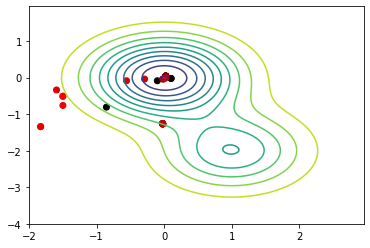

In [16]:
  def main():
    aoi = [0, 1]
    ch_len = 16
    num_arg = 2
    aoi = [-2, 2]

    Gen = GeneticAlgorithm(ch_len, num_arg, f, aoi, population_size=100, tournament_size = 3, num_steps = 50)
    Gen.run()
  if __name__ == "__main__":
    main()


Wykres dla populacji 100, ilosci krokow 50, aoi = [-2, 2]


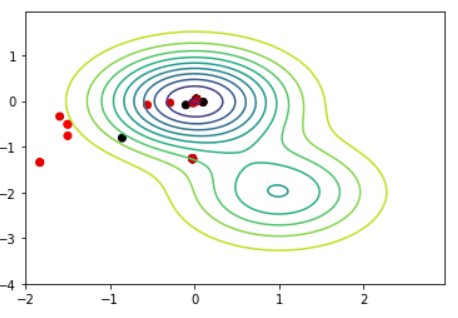

Wykres dla populacji 1000, ilosci krokow 50, aoi = [0, 1]


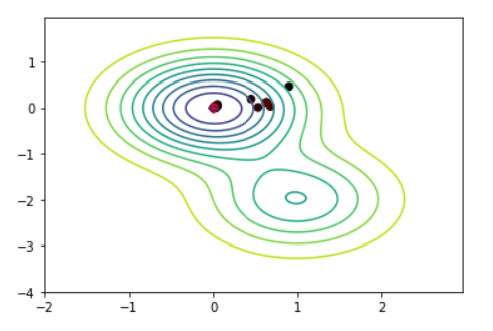